# H-Kr Scattering

In [2]:
import numpy as np
import scipy
import sys
import matplotlib.pyplot as plt
from scipy.integrate import simpson
import random
from random import randint
import scipy.constants as const
from scipy.signal import find_peaks


## Step 1: solving the Schrodinger equation


Constants and parameters

In [4]:

E = 1.5 #meV
epsilon = 5.99 # meV
sigma = 3. # Angstrom
rmax = 200 # Angstrom
h = 0.01 # spacing
N = rmax/h #number of points
r = np.arange(h/10, rmax, h)
l = 9


# - Masses:
#Kr mass = 83.798 u
#H mass = 1.008 u
# 1 u = 931.494 MeV
m_Kr = 83.798 #u
m_H = 1.008 #u
m = 931.494 * m_Kr * m_H /(m_Kr+ m_H) #MeV/c^2      reduced mass

# - Costants:
h_bar_Js = const.hbar #hbar in Js
h_bar = h_bar_Js / (1.6e-19) # hbar in eVs
c=const.c

# - Useful quantities:
a = 1e-3 * h_bar**2 *(c*1e10)**2/(2*m) #1e-3 for conversion meV, eV -> meV - 1e-10 for conversion m -> Å
b = (4*epsilon * (sigma**12) /(25*a))**(0.1)

print("a = ", a)
print("b = ", b)


a =  2.1041471061733663
b =  3.4545586969842805


Here we define the potential and the Numerov algorithm function

In [207]:
# Potential
def V(r,s):
    V = 4*epsilon * ((s/r)**12 - (s/r)**6) #meV
    return V


# Numerov
def Numerov(E,h,l,r,s):
    '''Numerov algorithm for the radial Schrodinger equation
    input: E: energy 
           h: step size
           l: angular momentum quantum number
           r: array of distances
           s: parameter for the potential 
    '''
    y = np.zeros(len(r))
    k = np.zeros(len(r))
    # Initialization of values
    for j in range(2, len(r)):
        k[j] = (1/a)*(E-V(r[j],s))-l*(l+1)/(r[j])**2
 
    for j in range(0, len(r)-1):
        if r[j]<=sigma/2:
            y[j]=np.exp(-(b/r[j])**5)
        else:
            y[j+1] = (-y[j-1]*(1+h**2/12*k[j-1])+2*y[j]*(1-(5*h**2)/12*k[j]))/((1+h**2/12*k[j+1]))
    return y


# Normalization
def normalize(psi,x):
  """ Normalization of the wavefunction calculing the integral of the wavefunction"""
  # Step 1: Compute the modulus squared of the wave function
  mod_squared_psi = np.abs(psi)**2

  # Step 2: Integrate the modulus squared over all space
  integral_value = simpson(mod_squared_psi, x)

  # Step 3: Calculate the normalization constant
  normalization_constant = 1 / np.sqrt(np.abs(integral_value))

  # Step 4: Apply the normalization constant
  normalized_psi = [y*normalization_constant for y in psi]
  return normalized_psi



For computational speed, we wrote a numerov.c function which we wrap into python. If the numerov.c piece of code doesn't work, one can simply substitute Numerov_C with Numerov everywhere it is called and it will work.

  ```c 
    #include <math.h>
    #include <stddef.h>

    // Function prototype (declare V before use)
    static inline double V(double r, double s);

    // Constants
    static const double epsilon = 5.99;
    static const double a = 2.1041471061733663;
    static const double b = 2.1236506034448093;

    // Lennard-Jones potential
    static inline double V(double r, double s) {
        const double sr = s / r;
        const double sr6 = pow(sr, 6);
        return 4.0 * epsilon * (sr6 * sr6 - sr6);
    }

    // Numerov solver (rest of the code remains the same)
    void numerov(double E, double h, int l, const double* r, const double* s, size_t n, double* y)  {
        double k[n];
        const double h_sq_12 = h * h / 12.0;
        const double sigma = s[0];  // Assume s is constant (σ in LJ potential)

        // Precompute k[j] = (1/a)(E - V(r,s)) - l(l+1)/r²
        for (size_t j = 2; j < n; j++) {
            k[j] = (1.0 / a) * (E - V(r[j], sigma)) - l * (l + 1) / (r[j] * r[j]);
        }

        // Initial condition: y[j] = exp(-(b/r[j])⁵) for r[j] ≤ σ/2
        for (size_t j = 0; j < n; j++) {
            if (r[j] <= sigma / 2.0) {
                y[j] = exp(-pow(b / r[j], 5));
            } else {
                y[j] = 0.0;  // Explicit initialization
            }
        }

        // Numerov iteration (avoids branching in inner loop)
        for (size_t j = 1; j < n - 1; j++) {
            if (r[j + 1] > sigma / 2.0) {
                const double denom = 1.0 + h_sq_12 * k[j + 1];
                y[j + 1] = (
                    -y[j - 1] * (1.0 + h_sq_12 * k[j - 1]) + 
                    2.0 * y[j] * (1.0 - 5.0 * h_sq_12 * k[j])
                ) / denom;
            }
        }
    }
```

compile

``` clang -shared -fPIC -o numerov.dylib numerov.c -lm #MacOs```

```gcc -shared -fPIC -o numerov.so numerov.c  # Linux```


here we wrap it

In [208]:
import ctypes
import numpy as np
from numpy.ctypeslib import ndpointer

# load the compiled library
lib = ctypes.CDLL('./numerov.dylib')  # macOS
# lib = ctypes.CDLL('./numerov.so')   # Linux 

# Define argument types
lib.numerov.argtypes = [
    ctypes.c_double,                     # E
    ctypes.c_double,                     # h
    ctypes.c_int,                        # l
    ndpointer(dtype=np.float64, flags="C_CONTIGUOUS"),  # r
    ndpointer(dtype=np.float64, flags="C_CONTIGUOUS"),  # s (treated as σ)
    ctypes.c_size_t,                     # n
    ndpointer(dtype=np.float64, flags="C_CONTIGUOUS"),  # y
]

def Numerov_C(E, h, l, r, sigma):
    """Python wrapper for the C numerov solver.
    Args:
        E: Energy (float)
        h: Step size (float)
        l: Angular momnetum quantum number (int)
        r: Radial grid (np.array)
        sigma: LJ parameter (float, converted to array)
    Returns:
        y: Wavefunction values (np.array)
    """
    y = np.zeros_like(r)
    s_array = np.full_like(r, sigma)  # Broadcast sigma to array
    lib.numerov(E, h, l, r, s_array, len(r), y)
    return y

verify that, for large r, the solutions are oscillatory with a phase depending on l

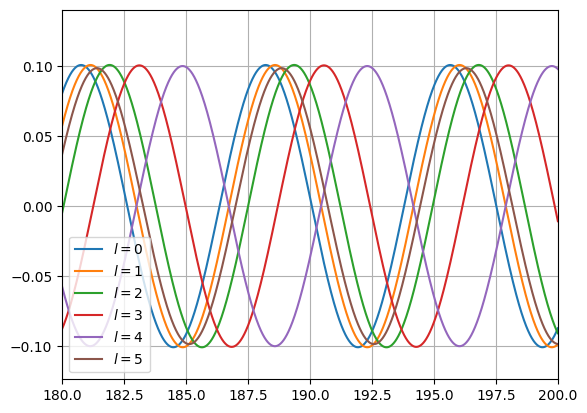

In [209]:
fig, ax = plt.subplots()
ax.set_xlim(180,200)
for j in range(6):
    psi = Numerov_C(E,h,j,r,sigma)
    PSI = normalize(psi,r)
    ax.plot(r, PSI, label=rf'$l={j}$')   
plt.legend(loc='best')
plt.grid()
plt.show()

## Step 2: phase shifts

define Bessel functions using the recursive method introduced in class

In [210]:
# Define Bessel functions

def j_1(r):
    return np.sin(r)/(r**2) - np.cos(r)/r
    
def n_1(r):
    return -np.cos(r)/(r**2) - np.sin(r)/r
    
    
def j_0(r):
    return np.sin(r)/r
    
def n_0(r):
    return -np.cos(r)/r
    

def recursive_bessel(l,sl,sl1,r):
    '''
    define the recursion relations
    input: l - order of bessel
            sl - l-th bessel evaluated at r
            sl1 - (l-1)-th bessel evaluated at r
            r - point to evaluate the bessel
    output: l+1 bessel, evaluated at r
    '''
    return ((2*l+1)/(r))*sl - sl1

def Bessel_l(l,r):
    """   
    define a function to create a matrix of Bessel functions
    input: l - maximum order of bessel, 
            r - array of r values
    output: two matrices of Bessels (one of first kind, one of second kind) of order 0,...,l-1 evaluated on an array r
    """
    bess_matj = np.zeros((l,len(r)))
    bess_matn = np.zeros((l,len(r)))

    for j in range(len(r)):
        bess_matj[0][j] = j_0(r[j])
        bess_matn[0][j] = n_0(r[j])
        bess_matj[1][j] = j_1(r[j])
        bess_matn[1][j] = n_1(r[j])
        
    for w in range(2,l):
        for j in range(len(r)):
            bess_matj[w][j] = recursive_bessel(w-1,bess_matj[w-1][j], bess_matj[w-2][j],r[j])
            bess_matn[w][j] = recursive_bessel(w-1,bess_matn[w-1][j], bess_matn[w-2][j],r[j])
            
    return bess_matj, bess_matn
  

Compare the recursion-relation Bessels against Scipy

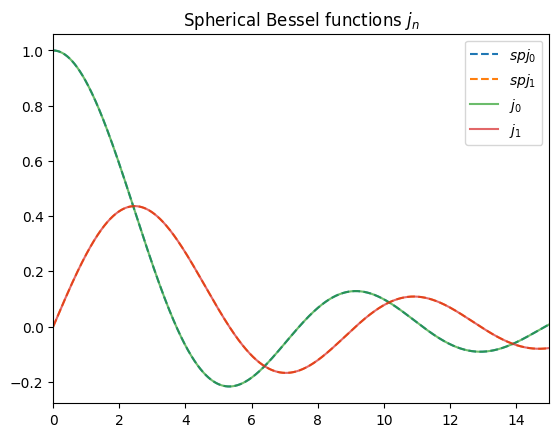

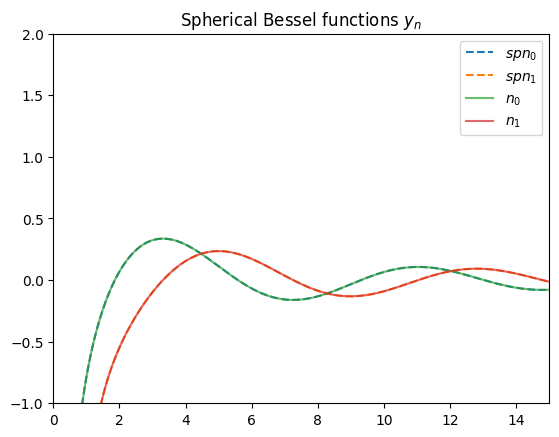

In [211]:
from scipy.special import spherical_jn
from scipy.special import spherical_yn

# bessels from recursion relations
jj, nn = Bessel_l(l,np.sqrt(1/a*E)*r) 


#first plot: spherical bessel functions of the first kind
fig, ax = plt.subplots()
ax.set_xlim(0, 15)
ax.set_title(r'Spherical Bessel functions $j_n$')
# scipy bessels are dashed
for n in np.arange(0, 2):
    ax.plot(r, spherical_jn(n, np.sqrt(1/a*E)*r), label=rf'$spj_{n}$', linestyle='dashed')   
# our bessels are solid
for n in np.arange(0, 2):
    ax.plot(r, jj[n][:], label=rf'$j_{n}$', alpha=0.7)
plt.legend(loc='best')
plt.show()

#second plot: spherical bessels of the second kind
fig, ax = plt.subplots()
ax.set_xlim(0, 15)
ax.set_ylim(-1,2)
ax.set_title(r'Spherical Bessel functions $y_n$')
# scipy bessels are dashed
for n in np.arange(0, 2):
    ax.plot(r, spherical_yn(n,np.sqrt(1/a*E)*r), label=rf'$spn_{n}$', linestyle='dashed')   
# our bessels are solid
for n in np.arange(0, 2):
    ax.plot(r, nn[n][:], label=rf'$n_{n}$', alpha=0.7)
plt.legend(loc='best')
plt.show()



Now onto computing the phase shifts.

First, define a phase-shift function. 

All our efforts round up to nought as we noticed the Scipy Bessels here are significantly faster (~10x). Regrettably, we will use scipy bessels here onwards.

In [212]:
#from now on: the bessels from scipy are actually ~10 times faster than ours. we will use those
from scipy.special import spherical_jn, spherical_yn
# scipy is better than me . these functions are significantly faster than the recursion relations
def Bessel_l_scipy(l, r):
    # Compute orders from 0 to l-1
    orders = np.arange(l)

    # Use broadcasting to get a (l, len(r)) matrix
    bess_matj = spherical_jn(orders[:, None], r[None, :])
    bess_matn = spherical_yn(orders[:, None], r[None, :])

    return bess_matj, bess_matn

def Phase_shift(r1,r2,r,l,En,lmax,sigma):
    '''
    define phase shift function
    input: r1,r2 - two points to evaluate the phase shift
        r - array of r values for numerov
        l - angular momentum
        En - energy
        lmax - maximum order of bessel
        sigma - parameter of the potential
    output: phase shift delta_l as defined in class
    '''
    jj, nn = Bessel_l_scipy(lmax,np.sqrt(1/a*En)*r)
    psi = Numerov_C(En,h,l,r,sigma)
    u = normalize(psi,r)
    kk=(u[r1]*r[r2])/(u[r2]*r[r1])
    tan_delta_l=(kk*jj[l][r2]-jj[l][r1])/(kk*nn[l][r2]-nn[l][r1])
    delta_l=np.arctan(tan_delta_l)
    return delta_l

# a simpler phase shift function if i only want tan delta l
def Phase_shift_tg(r1,r2,r,l,En,lmax,sigma):
    jj, nn = Bessel_l_scipy(lmax,np.sqrt(1/a*En)*r)
    psi = Numerov_C(En,h,l,r,sigma)
    u = normalize(psi,r)
    kk=(u[r1]*r[r2])/(u[r2]*r[r1])
    tan_delta_l=(kk*jj[l][r2]-jj[l][r1])/(kk*nn[l][r2]-nn[l][r1])
    return tan_delta_l




verify that the phase shift we find this way is independent of the choice of the two points r1,r2, for several energies and angular momenta

In [213]:
# (this cell takes forever to run)
#Define E and l vectors
energy_step = 0.1
Evec = [round(z,3) for z in np.arange(0.0,3.6,energy_step)]
Evec[0] = Evec[1]/10
lvec=[z for z in range(0,l,1)]
rep=10
lmax=l

SHIFTS = np.zeros((len(lvec),len(Evec),rep))

for i in range(len(lvec)):
    for j in range(len(Evec)):
        for k in range(rep):
            r1 =randint(6000,len(r)-1)
            rr=r[r1]*4/5-20*k*h
            r2 = round(rr/h)
            SHIFTS[i][j][k]=Phase_shift(r1,r2,r,lvec[i],Evec[j],lmax,sigma)

plot the result from the previous cell

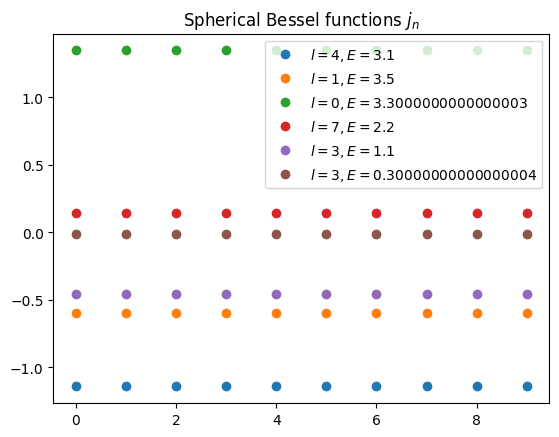

In [214]:
t = [z for z in range(0,rep,1)]

fig, ax = plt.subplots()
ax.set_title(r'Spherical Bessel functions $j_n$')
for j in range(6):
    aa = randint(0,len(Evec)-1)
    bb = randint(0,len(lvec)-1)
    ax.plot(t, SHIFTS[bb][aa][:], 'o',label=rf'$l={bb}, E={aa*energy_step}$')   

plt.legend(loc='best')
plt.show()

Mean and variance of phase shifts

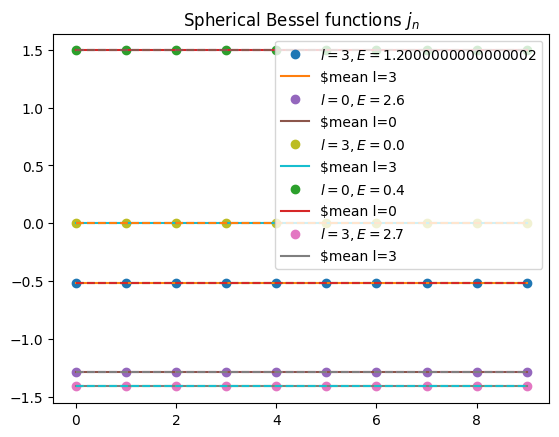

In [215]:
mean_shift=np.zeros((len(lvec),len(Evec)))
var_shift=np.zeros((len(lvec),len(Evec)))

for i in range(len(lvec)):
    for j in range(len(Evec)):
        sum=0
        sumq=0
        for k in range(rep):
            sum+=SHIFTS[i][j][k]
            sumq+=SHIFTS[i][j][k]**2        
        mean_shift[i][j]=sum/rep
        var_shift[i][j]=sumq/rep  - (sum/rep)**2
        

        
fig, ax = plt.subplots()
ax.set_title(r'Spherical Bessel functions $j_n$')
for j in range(5):
    aa = [round(1.2/energy_step),round(2.6/energy_step),round(0.005/energy_step),round(0.4/energy_step),round(2.7/energy_step)]#randint(0,len(Evec)-1)
    bb = [3,0,3,0,3]#randint(0,len(lvec)-1)
    ax.plot(t, SHIFTS[bb[j]][aa[j]][:], 'o',label=rf'$l={bb[j]}, E={aa[j]*energy_step}$')   
    ax.plot(t, np.ones(len(t))*mean_shift[bb[j]][aa[j]], label=rf'$mean l={bb[j]}')
    ax.plot(t, np.ones(len(t))*mean_shift[bb[j]][aa[j]]+var_shift[bb[j]][aa[j]], linestyle='dashed')
    ax.plot(t, np.ones(len(t))*mean_shift[bb[j]][aa[j]]-var_shift[bb[j]][aa[j]],  linestyle='dashed')

plt.legend(loc='best')
plt.show()



From this analysis, we can conclude that we can simply take 1 phase shift for each (E,l). Here is an example of calculation for $\sigma = 3$

In [216]:
l = 9
#Define E and l vectors
Evec2 = np.linspace(0.1,5, num=100)
lvec=[z for z in range(0,l,1)]

rep=1
lmax=l

mean_shift_tg = np.zeros((len(lvec),len(Evec2)))

r1 =randint(len(r)-100,len(r)-1)   
r2 =randint(len(r)-300,len(r)-200)   
print(r1,r2)    

for i in range(len(lvec)):
    for j in range(len(Evec2)):
            mean_shift_tg[i][j]=Phase_shift_tg(r1,r2,r,lvec[i],Evec2[j],lmax,sigma)



19996 19742


## Part 3: Cross section

\begin{equation}
\sigma_{\text{tot}}= \frac{4\pi a}{E} \sum_l (2l+1) \sin^2 \delta_l
\end{equation}
for $a=\hbar^2/2m$

compare what happens when using 6,7,8 as maximum angular momentum quantum number. First, look at partial waves

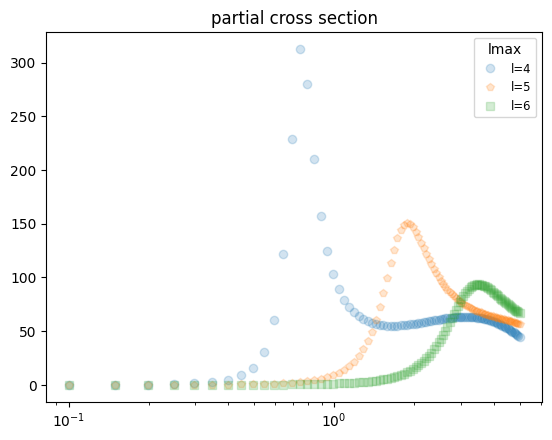

In [217]:
############## compute only partial cross sections
def partialcross(l,shifts,Evec):
    cross = np.zeros(len(Evec))
    for i in range(len(Evec)):
        a = 1e-3 * h_bar**2 *(c*1e10)**2/(2*m) #1e-3 for conversion meV, eV -> meV - 1e-10 for conversion m -> Å
        factor= 4 * a * np.pi/Evec[i]
        sum = 0
        tan_l = shifts[l][i]
        sin_squared = tan_l**2/(1+tan_l**2)
        sum+=(2*l+1)*sin_squared
        
        cross[i]=(factor*sum)
    return cross

pcross4 = partialcross(4,mean_shift_tg,Evec2)
pcross5 = partialcross(5,mean_shift_tg,Evec2)
pcross6 = partialcross(6,mean_shift_tg,Evec2)


fig, ax = plt.subplots()
ax.set_title(r'partial cross section')
ax.set_xscale('log')
#ax.set_ylim(0.9e2, 500)
#ax.set_xlim(0.1, 5)
ax.plot(Evec2, pcross4, 'o', alpha=.2)  
ax.plot(Evec2, pcross5, 'p', alpha=.2)  
ax.plot(Evec2, pcross6, 's', alpha=.2)  
#ax.set_ylim(10,500)
plt.legend(['l=4', 'l=5', 'l=6'], loc='best', title='lmax', fontsize='small')
plt.show()

Then, we turn onto the whole cross section for our given value of $\sigma$.

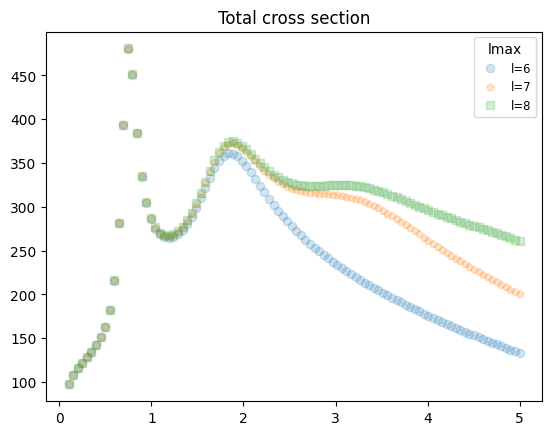

In [218]:
def totalcross(l,shifts,Evec):
    '''
    cross section functions
    input: l = maximum spherical harmonic + 1
           shifts = matrix of the tangent of phase shifts, as output by Phase_shift_tg for each l'<= l and E
           Evec = energy array
    '''
    cross = np.zeros(len(Evec))
    for i in range(len(Evec)):
        a = 1e-3 * h_bar**2 *(c*1e10)**2/(2*m) #1e-3 for conversion meV, eV -> meV - 1e-10 for conversion m -> Å
        factor= 4 * a * np.pi/Evec[i]
        sum = 0
        for k in range(l): #this way k = 0,...,l-1?
            tan_l = shifts[k][i]
            sin_squared = tan_l**2/(1+tan_l**2)
            sum+=(2*k+1)*sin_squared
        
        cross[i]=(factor*sum)
   
    return cross

cross6 = totalcross(6,mean_shift_tg,Evec2)
cross7 = totalcross(7,mean_shift_tg,Evec2)
cross8 = totalcross(8,mean_shift_tg,Evec2)

fig, ax = plt.subplots()
ax.set_title(r'Total cross section')
#ax.set_xscale('log')
ax.plot(Evec2, cross6, 'o', alpha=.2)  
ax.plot(Evec2, cross7, 'p', alpha=.2)  
ax.plot(Evec2, cross8, 's', alpha=.2)  
plt.legend(['l=6', 'l=7', 'l=8'], loc='best', title='lmax', fontsize='small')
plt.show()

We stick to l=8. Comparing the plot with the experimental peaks,

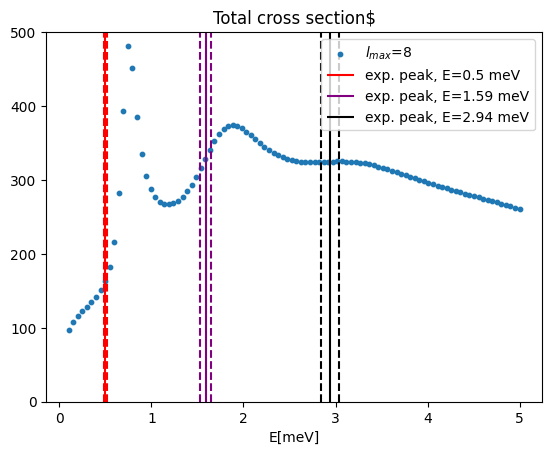

In [219]:
E_exp = [0.50,1.59,2.94] #meV
E_exp_err = [0.02,0.06,0.1] #meV

fig, ax = plt.subplots()
ax.set_title(r'Total cross section$')
ax.set_ylim(0,500)
plt.scatter(Evec2,cross8,label='$l_{max}$='f'{8}',s=10)
plt.xlabel('E[meV]')


plt.vlines(E_exp[0],0,500, color='red', label=f'exp. peak, E={E_exp[0]} meV')
plt.vlines(E_exp[0]+E_exp_err[0],0,500, color='red',linestyle='--')
plt.vlines(E_exp[0]-E_exp_err[0],0,500, color='red',linestyle='--')
plt.vlines(E_exp[1],0,500, color='purple', label=f'exp. peak, E={E_exp[1]} meV')
plt.vlines(E_exp[1]+E_exp_err[1],0,500, color='purple',linestyle='--')
plt.vlines(E_exp[1]-E_exp_err[1],0,500, color='purple',linestyle='--')
plt.vlines(E_exp[2],0,500, color='black', label=f'exp. peak, E={E_exp[2]} meV')
plt.vlines(E_exp[2]+E_exp_err[2],0,500, color='black',linestyle='--')
plt.vlines(E_exp[2]-E_exp_err[2],0,500, color='black',linestyle='--')
plt.legend()
plt.show()

Depending on the value of $\sigma$, scipy.signal.find_peaks might not even find three peaks. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


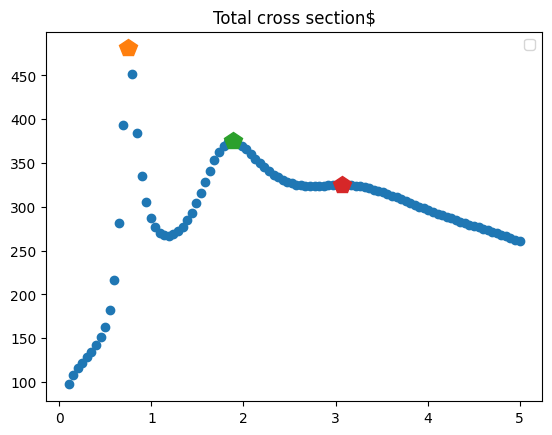

In [220]:
peaks_position8=[]
peak8, peak_position8 = find_peaks(cross8)
peaks_position8.append(list(peak8))

fig, ax = plt.subplots()
ax.set_title(r'Total cross section$')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.plot(Evec2,cross8,'o')
for i in range(len(peak8)):
    ax.plot(Evec2[peak8[i]], cross8[peak8[i]], 'p', markersize=13)
plt.legend(loc='best')
plt.show()

Thus we skim off the cases where the cross section does not have 3 peaks. We introduce an array of values of $\sigma$ (sigma_test), compute the total cross section as a function of energy (on the energy grid Evec3) 

computation time is of the order (on a beat-down laptop)

```3 min * len(Evec3) / 20 * len(sigma_test) / 50 * l / 8```

if we wanted to do better, we could find a faster normalisation (than our ~5 ms) (omitting normalisation would arguably not make the code better, as it would have to do several calculations with ridiculous numbers) and a faster way of computing Bessels (3-5 ms). Numerov runs in ~1 ms. Alternatively: buy a decent computer

In [221]:
Evec3 = np.linspace(0.2,3.5, num=200)
sigma_test=np.linspace(3,4,200)
l_fin = 9 #(due to off-by-one phenomena, this l_fin is actually l+1. This code is held together by a thread)
lvec3=[z for z in range(0,l_fin,1)]

SHIFTS_TEST = np.zeros((len(lvec3), len(Evec3)))

CROSS=[]

from tqdm import tqdm #for progress tracking on this slow bit of code
for k in tqdm(range(len(sigma_test))):
    for i in range(len(lvec3)):
        for j in range(len(Evec3)):
            SHIFTS_TEST[i][j]=Phase_shift_tg(r1,r2,r,lvec3[i],Evec3[j],l_fin,sigma_test[k])
    cross_test=totalcross(l_fin-1,SHIFTS_TEST,Evec3)
    CROSS.append(cross_test)



peaks_results = []

for i in range(len(sigma_test)):
    y = CROSS[i]
    peak_indices, _ = find_peaks(y)
    
    if len(peak_indices) == 3:
        peak_energies = Evec3[peak_indices]
        peak_cross_sections = y[peak_indices]

        result = {
            'sigma': sigma_test[i],
            'energies': peak_energies,
            'cross_sections': peak_cross_sections
        }
        
        peaks_results.append(result)
    else:
        print("Not the right number of peaks found for sigma =", sigma_test[i])

# --- Print results 
for res in peaks_results:
    print(f"\nSigma = {res['sigma']:.3f}")
    for e in zip(res['energies']):
        print(f"  Peak at E = {e[0]:.3f} meV") 
        

100%|██████████| 200/200 [1:45:36<00:00, 31.68s/it]

Not the right number of peaks found for sigma = 3.2964824120603016
Not the right number of peaks found for sigma = 3.301507537688442
Not the right number of peaks found for sigma = 3.306532663316583
Not the right number of peaks found for sigma = 3.3115577889447234
Not the right number of peaks found for sigma = 3.3165829145728645
Not the right number of peaks found for sigma = 3.321608040201005
Not the right number of peaks found for sigma = 3.3266331658291457
Not the right number of peaks found for sigma = 3.3316582914572863
Not the right number of peaks found for sigma = 3.3366834170854274
Not the right number of peaks found for sigma = 3.341708542713568
Not the right number of peaks found for sigma = 3.3467336683417086
Not the right number of peaks found for sigma = 3.8391959798994977
Not the right number of peaks found for sigma = 3.849246231155779
Not the right number of peaks found for sigma = 3.85929648241206
Not the right number of peaks found for sigma = 3.8743718592964824
No

Then we fit the experimental peaks against our result, looking to minimise 
\begin{equation}
\Delta^2 (\sigma) = \sum _{i=1}^3 (E_i^{\text{th}}(\sigma)-E_i^\text{exp})^2
\end{equation}

[0.15424401924193804, 0.14503775172344113, 0.12852300209590647, 0.12852300209590647, 0.11310822469129551, 0.10213683507992205, 0.08837201600969663, 0.07905058473270868, 0.07284207484659465, 0.06462061579253035, 0.053605727279614095, 0.04703422655993524, 0.03645416039998981, 0.03645416039998981, 0.02752405257442988, 0.024252468523522103, 0.017637468902300384, 0.016015843185778107, 0.013542072321406015, 0.013570404939269188, 0.009705335875356658, 0.011383626827605325, 0.011803282896896567, 0.014988035807176591, 0.013872897300573237, 0.01885110492159288, 0.023670649882578824, 0.028505361127244333, 0.03552485053407745, 0.03841827746774076, 0.047637711320421196, 0.05412238089947236, 0.06554175919800016, 0.07766978626802357, 0.09183909512386051, 0.09183909512386051, 0.10765836231408313, 0.1230863060528776, 0.13287089230069954, 0.15199007615969287, 0.1701679504557968, 0.1920370648720993, 0.1920370648720993, 0.21555613762278736, 0.2370339285876618, 0.2538096716244541, 0.2769374209237142, 0.301

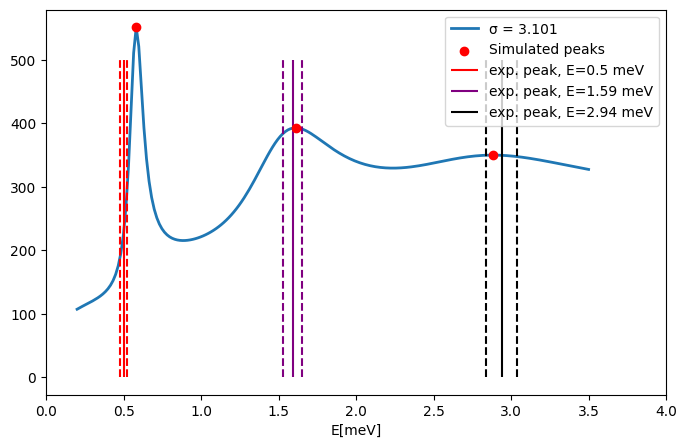

In [223]:
E_peaks_exp = [0.502, 1.589, 2.941] #Position of the experimental peaks in meV
E_exp = [0.50,1.59,2.94] #meV
E_exp_err = [0.02,0.06,0.1] #meV

DELTA=[]

for j in range(len(peaks_results)):
    delta=0
    for i in range(len(E_peaks_exp)):
       delta+=(E_peaks_exp[i]-peaks_results[j]['energies'][i] )**2
    DELTA.append(delta) 

print(DELTA)

best_index = np.argmin(DELTA)
best_result = peaks_results[best_index]

print(f"\nbest Sigma: {best_result['sigma']:.3f}")
print(f"experimental Sigma: 3.57 angstrom")
print(f"Minimum Delta: {DELTA[best_index]:.6f}")
print("Simulated peak energy:", best_result['energies'])



best_sigma = peaks_results[best_index]['sigma']

# find best cross section as the one with the given value of sigma
j = np.argmin(np.abs(sigma_test - best_sigma))
best_cross_section = CROSS[j]

# Plot
ax.set_title(r'Total cross section$')
plt.figure(figsize=(8,5))
plt.plot(Evec3, best_cross_section, label=f"σ = {best_sigma:.3f}", linewidth=2)
plt.scatter(peaks_results[best_index]['energies'], peaks_results[best_index]['cross_sections'],
            color='red', zorder=5, label='Simulated peaks')
plt.xlabel('E[meV]')
plt.vlines(E_exp[0],0,500, color='red', label=f'exp. peak, E={E_exp[0]} meV')
plt.vlines(E_exp[0]+E_exp_err[0],0,500, color='red',linestyle='--')
plt.vlines(E_exp[0]-E_exp_err[0],0,500, color='red',linestyle='--')
plt.vlines(E_exp[1],0,500, color='purple', label=f'exp. peak, E={E_exp[1]} meV')
plt.vlines(E_exp[1]+E_exp_err[1],0,500, color='purple',linestyle='--')
plt.vlines(E_exp[1]-E_exp_err[1],0,500, color='purple',linestyle='--')
plt.vlines(E_exp[2],0,500, color='black', label=f'exp. peak, E={E_exp[2]} meV')
plt.vlines(E_exp[2]+E_exp_err[2],0,500, color='black',linestyle='--')
plt.vlines(E_exp[2]-E_exp_err[2],0,500, color='black',linestyle='--')
plt.legend()
plt.xlim(0, 4)
plt.show()

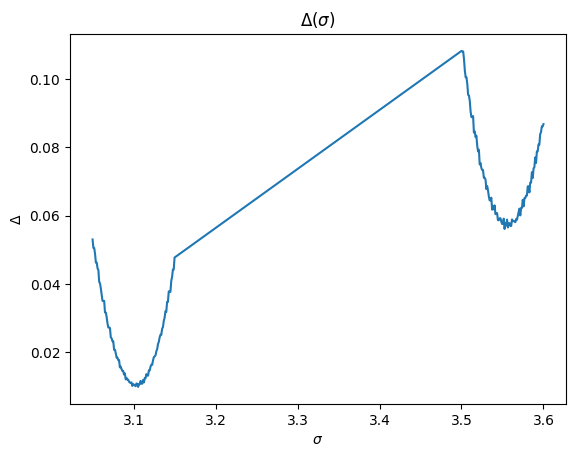

In [251]:
new_sigma = []
for i in range(len(peaks_results)):
    new_sigma.append(peaks_results[i]['sigma'])

plt.plot(new_sigma, DELTA)


plt.xlabel(r"$\sigma$")
plt.ylabel(r"$\Delta$")
plt.title(r"$\Delta(\sigma)$")
plt.show()

The optimal sigma seems to be either around 3.1 or 3.55. The value in the paper seems to be the latter. However our simulation seems to prefer the former. We can go into more detail and only look at data points for sigma close to these two values, and only conosidering energies close to the peaks.

In [247]:
# Create Evec4 with 50 equally spaced points between 0.2 and 3.5
Evec4 = np.linspace(0.2, 3.5, 50)

# Create 100 points in a 0.3 contour around E_peaks_exp
E_peaks_exp = np.array([0.502, 1.589, 2.941])
contour_points = []
for peak in E_peaks_exp:
    contour_points.extend(np.linspace(peak - 0.3, peak + 0.3, 100))
contour_points = np.array(contour_points)
Evec4 = np.sort(np.concatenate((Evec4, contour_points)))
# Create sigma_tests2 with 20 points between 3.05-3.15 and 20 points between 3.5-3.6
sigma_part1 = np.linspace(3.05, 3.15, 100)
sigma_part2 = np.linspace(3.5, 3.6, 100)
sigma_test2 = np.concatenate((sigma_part1, sigma_part2))

l_fin = 9 #(due to off-by-one phenomena, this l_fin is actually l+1. This code is held together by a thread)
lvec3=[z for z in range(0,l_fin,1)]

SHIFTS_TEST = np.zeros((len(lvec3), len(Evec4)))

CROSS=[]

from tqdm import tqdm #for progress tracking on this slow bit of code
for k in tqdm(range(len(sigma_test2))):
    for i in range(len(lvec3)):
        for j in range(len(Evec4)):
            SHIFTS_TEST[i][j]=Phase_shift_tg(r1,r2,r,lvec3[i],Evec4[j],l_fin,sigma_test2[k])
    cross_test=totalcross(l_fin-1,SHIFTS_TEST,Evec4)
    CROSS.append(cross_test)



peaks_results = []

for i in range(len(sigma_test2)):
    y = CROSS[i]
    peak_indices, _ = find_peaks(y)
    
    if len(peak_indices) == 3:
        peak_energies = Evec4[peak_indices]
        peak_cross_sections = y[peak_indices]

        result = {
            'sigma': sigma_test2[i],
            'energies': peak_energies,
            'cross_sections': peak_cross_sections
        }
        
        peaks_results.append(result)
    else:
        print("Not the right number of peaks found for sigma =", sigma_test2[i])

# --- Print results 
for res in peaks_results:
    print(f"\nSigma = {res['sigma']:.3f}")
    for e in zip(res['energies']):
        print(f"  Peak at E = {e[0]:.3f} meV") 
        

100%|██████████| 200/200 [3:02:44<00:00, 54.82s/it]  


Sigma = 3.050
  Peak at E = 0.663 meV
  Peak at E = 1.744 meV
  Peak at E = 2.999 meV

Sigma = 3.051
  Peak at E = 0.663 meV
  Peak at E = 1.737 meV
  Peak at E = 2.993 meV

Sigma = 3.052
  Peak at E = 0.663 meV
  Peak at E = 1.737 meV
  Peak at E = 2.993 meV

Sigma = 3.053
  Peak at E = 0.663 meV
  Peak at E = 1.731 meV
  Peak at E = 2.993 meV

Sigma = 3.054
  Peak at E = 0.657 meV
  Peak at E = 1.731 meV
  Peak at E = 2.986 meV

Sigma = 3.055
  Peak at E = 0.657 meV
  Peak at E = 1.731 meV
  Peak at E = 2.986 meV

Sigma = 3.056
  Peak at E = 0.657 meV
  Peak at E = 1.725 meV
  Peak at E = 2.986 meV

Sigma = 3.057
  Peak at E = 0.657 meV
  Peak at E = 1.725 meV
  Peak at E = 2.980 meV

Sigma = 3.058
  Peak at E = 0.650 meV
  Peak at E = 1.719 meV
  Peak at E = 2.980 meV

Sigma = 3.059
  Peak at E = 0.650 meV
  Peak at E = 1.719 meV
  Peak at E = 2.974 meV

Sigma = 3.060
  Peak at E = 0.650 meV
  Peak at E = 1.713 meV
  Peak at E = 2.974 meV

Sigma = 3.061
  Peak at E = 0.644 meV
  Pe

[0.05299357208448119, 0.050495867768595055, 0.050495867768595055, 0.04873278236914608, 0.0462350780532599, 0.0462350780532599, 0.0445454545454545, 0.04403122130394855, 0.040578512396694265, 0.04013774104683199, 0.03859504132231407, 0.036831955922865055, 0.034995408631772314, 0.034995408631772314, 0.034995408631772314, 0.031616161616161625, 0.031616161616161625, 0.030252923467762347, 0.028457300275482093, 0.02720844811753906, 0.02720844811753906, 0.027061524334251644, 0.02434343434343436, 0.024026171131251176, 0.02316804407713499, 0.02316804407713499, 0.02067033976124887, 0.02067033976124887, 0.019715335169880634, 0.018393021120293854, 0.018393021120293854, 0.01765840220385678, 0.01765840220385678, 0.0155280073461892, 0.015748393021120324, 0.01501377410468322, 0.014479429238429516, 0.014479429238429516, 0.0133976124885216, 0.013764921946740137, 0.012001836547291091, 0.01244260789715337, 0.011928374655647417, 0.011928374655647417, 0.011340679522497715, 0.011054317667990272, 0.01105431766

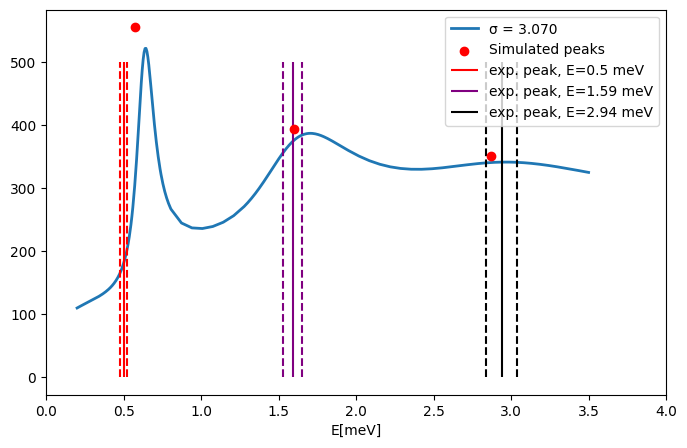

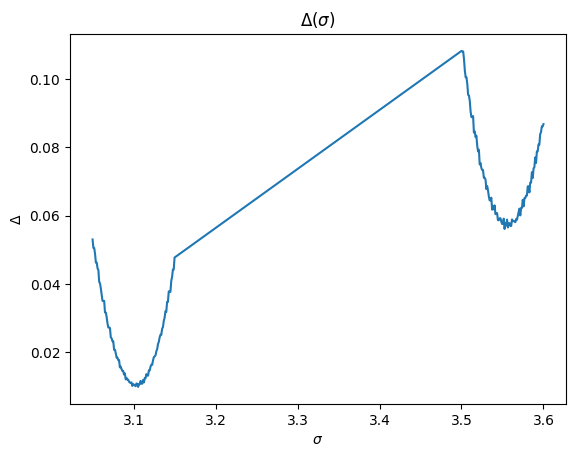


best Sigma: 3.106
experimental Sigma: 3.57 angstrom
Minimum Delta: 0.009798
Simulated peak energy: [0.57169697 1.59809091 2.87130303]


In [272]:
# find best cross section as the one with the given value of sigma

DELTA=[]

for j in range(len(peaks_results)):
    delta=0
    for i in range(len(E_peaks_exp)):
       delta+=(E_peaks_exp[i]-peaks_results[j]['energies'][i] )**2
    DELTA.append(delta) 

print(DELTA)
j = np.argmin(np.abs(sigma_test - best_sigma))
best_cross_section = CROSS[j]

best_index = np.argmin(DELTA)
best_result = peaks_results[best_index]

# Plot
ax.set_title(r'Total cross section$')
plt.figure(figsize=(8,5))
plt.plot(Evec4, best_cross_section, label=f"σ = {best_sigma:.3f}", linewidth=2)
plt.scatter(peaks_results[best_index]['energies'], peaks_results[best_index]['cross_sections'],
            color='red', zorder=5, label='Simulated peaks')
plt.xlabel('E[meV]')
plt.vlines(E_exp[0],0,500, color='red', label=f'exp. peak, E={E_exp[0]} meV')
plt.vlines(E_exp[0]+E_exp_err[0],0,500, color='red',linestyle='--')
plt.vlines(E_exp[0]-E_exp_err[0],0,500, color='red',linestyle='--')
plt.vlines(E_exp[1],0,500, color='purple', label=f'exp. peak, E={E_exp[1]} meV')
plt.vlines(E_exp[1]+E_exp_err[1],0,500, color='purple',linestyle='--')
plt.vlines(E_exp[1]-E_exp_err[1],0,500, color='purple',linestyle='--')
plt.vlines(E_exp[2],0,500, color='black', label=f'exp. peak, E={E_exp[2]} meV')
plt.vlines(E_exp[2]+E_exp_err[2],0,500, color='black',linestyle='--')
plt.vlines(E_exp[2]-E_exp_err[2],0,500, color='black',linestyle='--')
plt.legend()
plt.xlim(0, 4)
plt.show()

new_sigma2 = []
for i in range(len(peaks_results)):
    new_sigma2.append(peaks_results[i]['sigma'])

plt.plot(new_sigma2, DELTA)

plt.xlabel(r"$\sigma$")
plt.ylabel(r"$\Delta$")
plt.title(r"$\Delta(\sigma)$")
plt.show()


The 3.1 value is still favoured, against our best hopes. Our final estimate is 

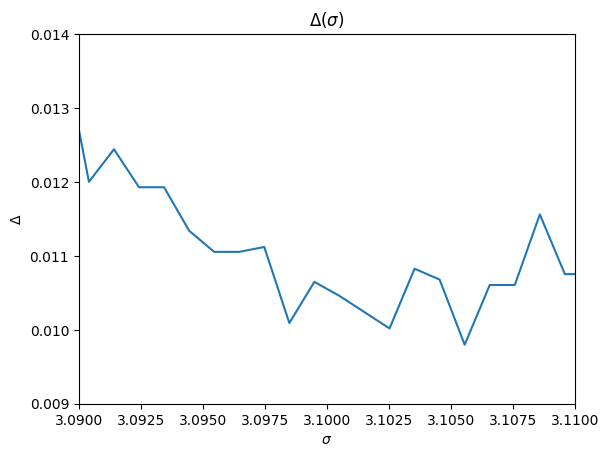


best Sigma: 3.106


In [280]:
plt.plot(new_sigma2, DELTA)

plt.xlabel(r"$\sigma$")
plt.ylabel(r"$\Delta$")
plt.title(r"$\Delta(\sigma)$")
plt.xlim(3.09,3.11)
plt.ylim(0.009,0.014)
plt.show()

print(f"\nbest Sigma: {best_result['sigma']:.3f}")



From the plot we estimate
\begin{equation}
\sigma = 3.11 \pm 0.05 \text{ Å}
\end{equation}